In [30]:
from commonfunctions import *
import skimage.io as io
from skimage import transform
from skimage.morphology import binary_erosion, binary_dilation
from skimage import measure
import cv2
from skimage.filters import threshold_otsu
import imutils
from skimage.transform import hough_line, hough_line_peaks , probabilistic_hough_line
from skimage.transform import rotate
from skimage.color import rgb2gray,rgb2hsv,rgba2rgb
from skimage.measure import regionprops , regionprops_table
from scipy.stats import mode
from imutils.perspective import four_point_transform
from skimage.transform import rescale, resize
from matplotlib import pyplot as plt
import pytesseract
import pandas as pd
import numpy as np
from skimage.feature import hog,SIFT,local_binary_pattern
import math
import pickle
import openpyxl
from openpyxl.styles import PatternFill

In [31]:
# user input functions

def getFile():
    return input('Please enter name of the image or its relative path with its file extension, ex: gradesheet_1.png :')

def getUseOCR():
    while True:
        temp = input('press 1 to use OCR for numbers, 2 to use our classifier :')
        if temp=='1' or temp == '2':
            return temp

In [32]:
# classifier functions
#OCR Implementation
def run_ocr(image):
    pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
    image = (image * 255).astype(np.uint8)  # tesseract only works with uint8 images so we convert image to this type
    options = "outputbase digits" # configuring tesseract to only detect numbers
    text = pytesseract.image_to_string(image, config=options) # tesseract gets us the number
    return text
    
def binary_threshold(image,threshold):
    thresh = np.zeros_like(image)
    thresh[image >= threshold] = 255
    thresh[image < threshold] = 0
    return thresh

def Segmnet_id(image):
    last_zero = 0
    digits_found = []
    in_number = False
    
    row_sum = np.sum(image,axis=1)   # eliminating horizontal lines
    horizontal_detected = []
    for i in range(len(row_sum)):
        if (row_sum[i] > 255*image.shape[1]*0.9):
            horizontal_detected.append(i)
    for i in range(len(horizontal_detected)):
        image[i,:] = 0

    column_sum = np.sum(image,axis=0)
    column_sum[column_sum > 255*image.shape[0]*0.9] = 0   # this could cause error but it should handle vertical lines

    for i in range(column_sum.shape[0]):
        if (column_sum[i] == 0 and in_number == False):
            last_zero = i
            continue

        if (column_sum[i] == 0 and in_number == True):
            in_number = False
            digits_found.append(image[:,last_zero:i+1])
            last_zero = i
            if (len(digits_found) == 7):
                break
            continue

        in_number = True
    
    return digits_found


def getThreshold(image):
    hist = np.zeros(256)
    for i in range(len(hist)):
        hist[i] = np.sum(image == i)
    
    Thist = 0

    for i in range(len(hist)):
        Thist += i * hist[i]
    Thist = round(Thist / (image.shape[0] * image.shape[1]))
    Tnew = 0
    Told = Thist
    c = 0
    # print(Told)
    while (Tnew != Told):
        if c > 0:
            Told = Tnew
        else:
            c += 1
        Tlow = 0 
        Thigh = 0
        for i in range(0, Told):
            Tlow += i * hist[i]
        sumLow = np.sum(hist[0:Told])
        
        Tlow = round(Tlow / sumLow) if not math.isnan(Tlow / sumLow) else 255
        for i in range(Told, 256):
            Thigh += i * hist[i]
        sumHigh = np.sum(hist[Told:])
        Thigh = round(Thigh / sumHigh) if not math.isnan(Thigh / sumHigh) else 255

        Tnew = round((Tlow + Thigh) / 2) 
    
    return Tnew

def invert(img):
    return 255 - img 

def Prepare_Extraction(images):
    for i in range(len(images)):
        resized_img = resize(images[i], (128,64))
        resized_img = (resized_img * 255).astype(np.uint8)
        threshold = getThreshold(resized_img)
        resized_img = binary_threshold(resized_img,threshold)
        images[i] = resized_img
    
    return images

def Extract_lbp(images):
    X_train = []
    descriptor_extractor = SIFT()
    for i in range(len(images)):
        lbp = local_binary_pattern(images[i], 3, 1)
        X_train.append(lbp.flatten())
    
    return X_train

def Extract_Hog(images):
    X_train = []
    hog_images = []

    for i in range(len(images)):
        fd,im = hog(images[i], orientations=8, pixels_per_cell=(2,2),cells_per_block=(4,4),visualize=True)
        X_train.append(fd)
        hog_images.append(im)
    
    return X_train,hog_images

def classify_character(image,is_id,use_ocr):
    x_test = []
    loaded_model = ""

    if (is_id):
        if (not use_ocr):
            image = 255 - image # invert image for calculations
        
            digits_found = Segmnet_id(image)
            
            if (len(digits_found) != 7):
                return "Failed to segment id"

            for i in range(7):
                digits_found[i] = invert(digits_found[i]) # returning to white background to match dataset
            

            digits_found = Prepare_Extraction(digits_found)
        
            features,hogplots = Extract_Hog(digits_found)
        
            x_test = features

            filename =  'our_numbers_rf.sav'
            loaded_model = pickle.load(open(filename, 'rb'))
        
        else:
            
            return str(run_ocr(image))
    
    else:

        images = []
        images.append(image)
        images = Prepare_Extraction(images)
        features,hogplots = Extract_Hog(images)
        x_test = features
        
        filename =  'All_hog_rf.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
    
    prediction = loaded_model.predict(x_test)

    if (len(prediction) > 1):
        string = ''
        for i in prediction:
            string += str(i)
        
        return string
    else:
        return prediction[0]

def character_output(character):
    if character == '1':
        return '1'
    elif character == '2':
        return '2'
    elif character == '3':
        return '3'
    elif character == '4':
        return '4'
    elif character == '5':
        return '5'
    elif character == '6':
        return '6'
    elif character == '7':
        return '7'
    elif character == '8':
        return '8'
    elif character == '9':
        return '9'
    elif character == '0':
        return '0'
    
    elif character == 'x':
        return '0'
    elif character == 'check':
        return '5'
    elif character == '?':
        return 'Red_empty'
    elif character == '_':
        return '0'
    elif character == 'V1':
        return '1'
    elif character == 'V2':
        return '2'
    elif character == 'V3':
        return '3'
    elif character == 'V4':
        return '4'
    elif character == 'V5':
        return '5'
    elif character == 'H1':
        return '4'
    elif character == 'H2':
        return '3'
    elif character == 'H3':
        return '2'
    elif character == 'H4':
        return '1'
    elif character == 'H5':
        return '0'
    elif character == 'empty':
        return 'empty'
    else:
        return 'unidentified'

In [33]:
# define a function that gets the edges of the image
def get_edges (img):
    # convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # apply gaussian blur to remove the noise
    img_gray = cv2.GaussianBlur(img_gray, (9, 9), 0)
    # apply canny edge detection
    edges = cv2.Canny(img_gray, 65, 150)
    # apply dilation to fill the holes
    dilated = cv2.dilate(edges,np.ones((5,5)) , iterations=3)
    # apply erosion to remove the noise
    eroded = cv2.erode(dilated,np.ones((5,5)) , iterations=1)
    return eroded 

In [34]:
# define a function that gets the contours of the image and detect the corners
def find_corners(img):
    # detect the corners of the largest contour
    contours = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
    corners = None
    
    for cnt in contours:
        perimeter = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)
        if len(approx) >= 4:
            corners = approx
            break
    return corners

In [35]:
# order the points in the contour such that they appear in top-left, top-right, bottom-right, and bottom-left order
# the top-left point has the smallest sum whereas the bottom-right has the largest sum
# the top-right point has the smallest difference whereas the bottom-left has the largest difference
# hence we can use the argmin and argmax functions to find the points in the correct order
def arrange_points(points):
    rect = np.zeros((4, 2), dtype = "float32")
    points_sum = points.sum(axis = 1)
    # top-left corner
    rect[0] = points[np.argmin(points_sum)]
    # bottom-right corner
    rect[2] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis = 1)
    # top-right corner
    rect[1] = points[np.argmin(points_diff)]
    # bottom-left corner
    rect[3] = points[np.argmax(points_diff)]
    # return the ordered coordinates of the rectangle
    return rect

In [36]:
# this function takes the arranged points and determines the width of the output image
def calculate_max_width(arranged_corners):
    (top_left, top_right, bottom_right, bottom_left) = arranged_corners
    # compute the width of the new image,
    # which will be the maximum distance between bottom-right and bottom-left x-coordinates or the top-right and top-left x-coordinates
    width_bot = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
    width_top = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
    max_width = max(int(width_bot), int(width_top))
    return max_width

In [37]:
# this function takes the arranged points and determines the height of the output image
def calculate_max_height(arranged_corners):
    (top_left, top_right, bottom_right, bottom_left) = arranged_corners
    # compute the height of the new image,
    # which will be the maximum distance between the top-right and bottom-right y-coordinates or the top-left and bottom-left y-coordinates
    height_right = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
    height_left = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))
    max_height = max(int(height_right), int(height_left))
    return max_height

In [38]:
def correct_perspective(original_img):
    img = original_img.copy()
    edged_img = get_edges(img)
    img = edged_img.copy()
    #Find the corners of the page 
    corners = find_corners(img)
    # put the corners in the right order
    arranged_corners = arrange_points(corners.reshape(4, 2))
    # Determine the coordinates of the new image 
    max_width = calculate_max_width(arranged_corners)
    max_height = calculate_max_height(arranged_corners)

    #########################################################################################################################################
    ############################## Correct the prespective of the image #####################################################################
    correct_perspective = np.array([0 , 0 , max_width - 1 , 0 , max_width - 1 , max_height - 1 , 0 , max_height - 1] , dtype= "float32").reshape((4, 2))
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(arranged_corners, correct_perspective)
    warped = cv2.warpPerspective(original_img, M, (max_width, max_height))
    return warped

success


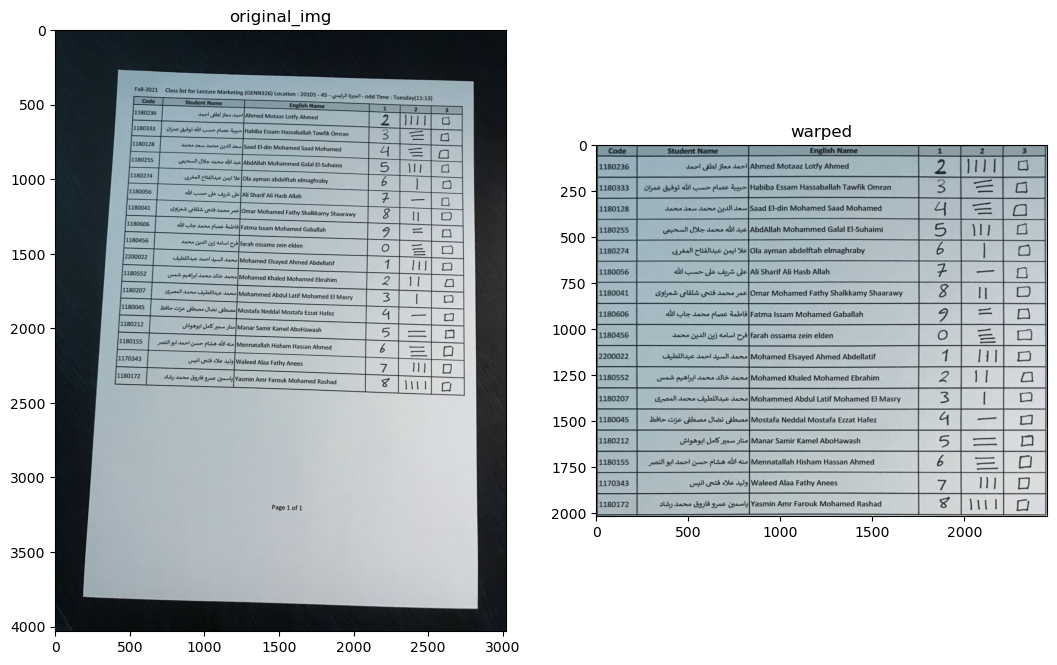

True

In [39]:
#########################################################################################################################################
################################# Get the edges of the image ############################################################################
# read image using opencv
original_img = cv2.imread(getFile())
answer_for_ocr = getUseOCR()
warped = correct_perspective(original_img)
try:
    warped = correct_perspective(warped)
    print('success')
except:
    print('error')
    pass
show_images([original_img,warped], ['original_img' , 'warped'])
# save the warped image
cv2.imwrite('warped.jpg', warped)

In [40]:
def sort_contours(cnts, method="left-to-right"):
	# initialize the reverse flag and sort index
	reverse = False
	i = 0
	# handle if we need to sort in reverse
	if method == "right-to-left" or method == "bottom-to-top":
		reverse = True
	# handle if we are sorting against the y-coordinate rather than
	# the x-coordinate of the bounding box
	if method == "top-to-bottom" or method == "bottom-to-top":
		i = 1
	# construct the list of bounding boxes and sort them from top to
	# bottom
	boundingBoxes = [cv2.boundingRect(c) for c in cnts]
	(cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
		key=lambda b:b[1][i], reverse=reverse))
	# return the list of sorted contours and bounding boxes
	return (cnts, boundingBoxes)


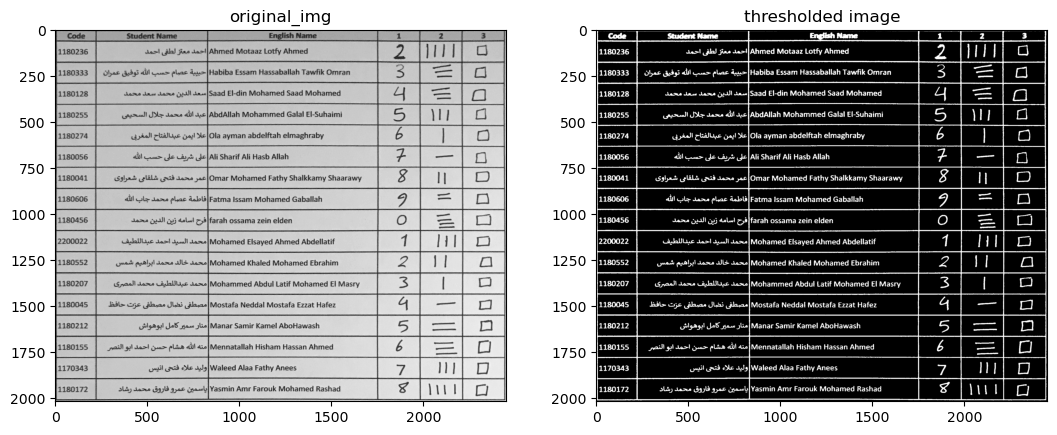

In [41]:
# https://medium.com/coinmonks/a-box-detection-algorithm-for-any-image-containing-boxes-756c15d7ed26
# read imageusing cv2.imread() method
pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

empty_red = []

use_ocr = True

if answer_for_ocr == '1':
    use_ocr = True
else:
    use_ocr = False

file = 'warped.jpg'
# load the image in grayscale mode
img = cv2.imread(file , 0)
# apply thresholding
ret, img_bin = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255-img_bin
show_images([img , img_bin],['original_img','thresholded image'])

# define a kernel size 
kernel_size = np.array(img).shape[1]//100
# define kernel for detecing vertical lines
v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_size))
# define kernel for detecing horizontal lines
h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, 1))
# define kernel of 3x3 ones
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
# detect vertical lines using morphology
v_lines = cv2.erode(img_bin, v_kernel, iterations=3)
v_lines = cv2.dilate(v_lines, v_kernel, iterations=3)
# detect horizontal lines using morphology
h_lines = cv2.erode(img_bin, h_kernel, iterations=3)
h_lines = cv2.dilate(h_lines, h_kernel, iterations=3)
# combine horizontal and vertical lines both with the same weight 0.5
# lines = cv2.add(h_lines, v_lines)
img_final_bin = cv2.addWeighted(v_lines, 0.5, h_lines, 0.5, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#########################################################################################################################################
#########################################################################################################################################
bitxor = cv2.bitwise_xor(img,img_final_bin)
bitnot = cv2.bitwise_not(bitxor)
# cv2.imwrite("bitxor.jpg",bitxor)
# cv2.imwrite("bitnot.jpg",bitnot)
# show_images([img, img_final_bin, bitxor, bitnot],['original_img','img_final_bin','bitxor','bitnot'])
#########################################################################################################################################
#########################################################################################################################################
# cv2.imwrite("img_final_bin.jpg",img_final_bin)
# find contours
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# sort contours from top to bottom
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

#########################################################################################################################################
######################################## Retrieve the cells position ####################################################################
# retrive the height of each cell
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
# get the mean of all the heights
heights_mean = np.mean(heights)

# create a list to store the cells and store their position , height and width
cells = []
# loop over the contours
for c in contours:
    # get the bounding box
    x, y, w, h = cv2.boundingRect(c)
    if (w < 1000 and h < 500 and h > 30 and w > 30):
        # draw the rectangle
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # store the cell in the list
        cells.append([x, y, w, h])
cv2.imwrite("testinggg.jpg", img)
#########################################################################################################################################
#########################################################################################################################################
# create a list to store the rows
row = []
# create a list to store the columns
column = []
# sorting the cells to get the rows and columns
for i in range(len(cells)):
    if i == 0:
        column.append(cells[i])
        previous = cells[i]
    else:
        if cells[i][1] <= previous[1] + heights_mean/2:
            column.append(cells[i])
            previous = cells[i]
            if i == len(cells)-1:
                row.append(column)
        else:
            row.append(column)
            column = []
            previous = cells[i]
            column.append(cells[i])
#########################################################################################################################################
#########################################################################################################################################
# get the maximum number of columns``
columns_count = 0
for i in range(len(row)):
    if len(row[i]) > columns_count:
        columns_count = len(row[i])
# get the center of each column
col_center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
col_center = np.array(col_center)
col_center.sort()

# arrange the cells in the correct order
final_cells = []
for i in range(len(row)):
    final_list = []
    for k in range(columns_count):
        final_list.append([])
    for j in range(len(row[i])):
        difference = abs(col_center-(row[i][j][0]+row[i][j][2]/4))
        min_value = min(difference)
        indexing = list(difference).index(min_value)
        final_list[indexing].append(row[i][j])
    final_cells.append(final_list)
# print (final_cells)
# print ("rows: ", row , "ENDDDDDD")
# print("rows length: ", len(row))
# print ("column: " ,column)
#########################################################################################################################################
#########################################################################################################################################
outer=[]
# i --> row , j --> column 
for i in range(len(final_cells)):
    for j in range(len(final_cells[i])):
        inner=''
        if(len(final_cells[i][j])==0):
            outer.append(' ')
        else:
            if j == 1 or j == 2 or i==0:
                out = ''
                outer.append(out)
            else:
                y,x,w,h = final_cells[i][j][0][0],final_cells[i][j][0][1], final_cells[i][j][0][2],final_cells[i][j][0][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=1)
                #print("i = ", i, "j = ", j)
                #show_images([erosion],['erosion'])

                ###############################################

                if j == 0:
                    string = classify_character(erosion,True,use_ocr) # id string retrieved
                    out = string
                else:
                    string = classify_character(erosion,False,use_ocr)
                    out = character_output(string)
                    
                    if out == 'Red_empty':
                        out = " "
                        empty_red.append((i,j))
                    
                    if out == 'empty':
                        out = " "

                ##################################################
                
                inner = inner +" "+ out
                outer.append(inner)


In [42]:
#Creating a dataframe of the generated OCR list
redFill = PatternFill(start_color='FFFF0000',
                   end_color='FFFF0000',
                   fill_type='solid')

numbers_to_letters = {
    0:'B',
    1:'C',
    2:'D',
    3:'E',
    4:'F',
    5:'G',
    6:'H',
    7:'I',
    8:'J',
    9:'K',
    10:'L',
    11:'M',
    12:'N'
}

arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row),columns_count))
print(dataframe)
data = dataframe.style.set_properties(align="left")
#Converting it in a excel-file
data.to_excel("output.xlsx")

for i in range(len(empty_red)):
    wb_obj = openpyxl.load_workbook('output.xlsx')
    sheet_obj = wb_obj.active
    cell = numbers_to_letters[empty_red[i][1] - 2]
    cell = cell + str(empty_red[i][0])
    sheet_obj[cell].fill = redFill
wb_obj.save('output.xlsx')

               0 1 2   3   4   5
0                               
1      1180236\n       5   4   3
2    1180333\n\n       1   1   2
3    1180128\n\n       1   0   3
4      1180255\n       9   5   2
5                      1   1   0
6    1180056\n\n       1   4   2
7      1180041\n       1   1   9
8      1180606\n       1   4   0
9    1180456\n\n       1   1   1
10   2200022\n\n           5   0
11   1180552\n\n       5   2   1
12     1180207\n       1   1    
13   1180045\n\n       1   4   1
14   1180212\n\n       1   3   1
15     1180155\n       1   0   1
16     1170343\n       5   4   2
17     1180172\n       5   4   2
